In [1]:
import sys,os,errno,signal,copy
from contextlib import contextmanager

import numpy as np
import musicnet

import torch
from torch.autograd import Variable
from torch.nn.functional import conv1d, mse_loss

from time import time

import matplotlib.pyplot as plt
from IPython.display import Audio

from sklearn.metrics import average_precision_score

root = './musicnet'
checkpoint_path = './checkpoints'
checkpoint = 'musicnet_demo.pt'

try:
    os.makedirs(checkpoint_path)
except OSError as e:
    if e.errno != errno.EEXIST:
        raise

%matplotlib inline

In [2]:
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'   # see issue #152
os.environ['CUDA_VISIBLE_DEVICES']='1'

def worker_init(args):
    signal.signal(signal.SIGINT, signal.SIG_IGN) # ignore signals so parent can handle them
    np.random.seed(os.getpid() ^ int(time())) # approximately random seed for workers

batch_size = 100
kwargs = {'num_workers': 4, 'pin_memory': True, 'worker_init_fn': worker_init}

m = 128
k = 500
d = 4096
window = 16384
stride = 512
regions = 1 + (window - d)/stride

In [3]:
train_set = musicnet.MusicNet(root=root, train=True, download=True, window=window)#, pitch_shift=5, jitter=.1)
test_set = musicnet.MusicNet(root=root, train=False, window=window, epoch_size=50000)

In [4]:
train_loader = torch.utils.data.DataLoader(dataset=train_set,batch_size=batch_size,**kwargs)
test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=batch_size,**kwargs)

In [5]:
def create_filters(d,k,low=50,high=6000):
    x = np.linspace(0, 2*np.pi, d, endpoint=False)
    wsin = np.empty((k,1,d), dtype=np.float32)
    wcos = np.empty((k,1,d), dtype=np.float32)
    start_freq = low
    end_freq = high
    num_cycles = start_freq*d/44000.
    scaling_ind = np.log(end_freq/start_freq)/k
    window_mask = 1.0-1.0*np.cos(x)
    for ind in range(k):
        wsin[ind,0,:] = window_mask*np.sin(np.exp(ind*scaling_ind)*num_cycles*x)
        wcos[ind,0,:] = window_mask*np.cos(np.exp(ind*scaling_ind)*num_cycles*x)
    
    return wsin,wcos

In [6]:
def init_weights(scale=0.):
    wscale = 0.
    with torch.cuda.device(0):
        beta = Variable(wscale*torch.rand(regions*k,m).cuda(), requires_grad=True)
        betaavg = Variable(beta.data.clone(), requires_grad=False)
    return (beta,), (betaavg,)

def L(y_hat, y):
    # adjust for per-frame loss
    return mse_loss(y_hat, y)*128/2.

In [7]:
class Model(torch.nn.Module):
    def __init__(self, avg=.9998):
        super(Model, self).__init__()
        
        wsin,wcos = create_filters(d,k)
        with torch.cuda.device(0):
            self.wsin_var = Variable(torch.from_numpy(wsin).cuda(), requires_grad=False)
            self.wcos_var = Variable(torch.from_numpy(wcos).cuda(), requires_grad=False)
        
        self.linear = torch.nn.Linear(regions*k, m, bias=False).cuda()
        torch.nn.init.constant(self.linear.weight, 0)
        
        self.avg = avg
        self.averages = copy.deepcopy(list(parm.data for parm in self.parameters()))
        for (name,parm),pavg in zip(self.named_parameters(),self.averages):
            self.register_buffer(name + '.avg', pavg)
    
    def forward(self, x):
        zx = conv1d(x[:,None,:], self.wsin_var, stride=stride).pow(2) \
           + conv1d(x[:,None,:], self.wcos_var, stride=stride).pow(2)
        return self.linear(torch.log(zx + musicnet.epsilon).view(x.data.size()[0],regions*k))
    
    def average_iterates(self):
        for parm, pavg in zip(self.parameters(), self.averages):
            pavg.mul_(self.avg).add_(1.-self.avg, parm.data)

@contextmanager
def averages(model):
    orig_parms = copy.deepcopy(list(parm.data for parm in model.parameters()))
    for parm, pavg in zip(model.parameters(), model.averages):
        parm.data.copy_(pavg)
    yield
    for parm, orig in zip(model.parameters(), orig_parms):
        parm.data.copy_(orig)

# Train the model

In [8]:
model = Model()
print model
loss_history = []
avgp_history = []

Model(
  (linear): Linear(in_features=12500, out_features=128)
)


In [9]:
# (optional) restore from checkpoint, if it exists
try:
    model.load_state_dict(torch.load(os.path.join(checkpoint_path,checkpoint)))
except IOError as e:
    if e.errno != errno.ENOENT:
        raise

In [10]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.000001, momentum=.95)

try:
    with train_set, test_set:
        print 'square loss\tavg prec\ttime\t\tutime'
        for epoch in xrange(50):
            t = time()
            for i, (x, y) in enumerate(train_loader):
                x, y = Variable(x.cuda(), requires_grad=False), Variable(y.cuda(), requires_grad=False)
                loss = L(model(x),y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                model.average_iterates()

            t1 = time()
            avgp, loss = 0., 0.
            yground = torch.FloatTensor(batch_size*len(test_loader), m)
            yhat = torch.FloatTensor(batch_size*len(test_loader), m)
            with averages(model):
                for i, (x, y) in enumerate(test_loader):
                    x, y = Variable(x.cuda(), requires_grad=False), Variable(y.cuda(), requires_grad=False)
                    yhatvar = model(x)
                    loss += L(yhatvar,y).data[0]
                    yground[i*batch_size:(i+1)*batch_size,:] = y.data
                    yhat[i*batch_size:(i+1)*batch_size,:] = yhatvar.data
            avgp = average_precision_score(yground.numpy().flatten(),yhat.numpy().flatten())
            loss_history.append(loss/len(test_loader))
            avgp_history.append(avgp)
            torch.save(model.state_dict(), os.path.join(checkpoint_path,checkpoint))
            print '{:2f}\t{:2f}\t{:2f}\t{:2f}'.format(loss_history[-1],avgp_history[-1],time()-t, time()-t1)

except KeyboardInterrupt:
    print 'Graceful Exit'
else:
    print 'Finished'

square loss	avg prec	time		utime
0.987603	0.619252	16.130471	5.872897
0.875406	0.635109	15.652778	5.966334
0.799570	0.641194	15.408463	5.806143
0.753370	0.648488	15.408362	5.901344
0.732434	0.652655	15.480956	6.007286
0.710257	0.654443	15.544183	5.898220
0.695311	0.654420	15.469090	5.825485
0.686031	0.655459	15.685776	5.971092
0.686979	0.660641	15.994876	6.064323
0.683197	0.660135	15.838411	5.980943
0.683973	0.658685	15.746585	5.920561
0.685610	0.662146	15.975401	5.994946
0.685071	0.659429	15.639058	5.958607
0.688860	0.659964	15.773201	6.053174
0.685270	0.660941	15.834801	6.088040
0.686830	0.663015	15.758342	5.977397
0.685074	0.663000	15.746188	5.934922
0.684551	0.663238	15.710092	6.034682
0.686186	0.667218	15.667789	5.933800
0.686267	0.663962	15.815468	6.114007
0.681922	0.666803	15.623409	5.943608
0.687653	0.665288	15.778395	5.993432
0.688804	0.662661	15.636869	5.976880
0.684755	0.663670	15.744015	5.857406
0.689110	0.663290	15.750354	5.931325
0.686575	0.663499	15.743198	5.978112
0.684

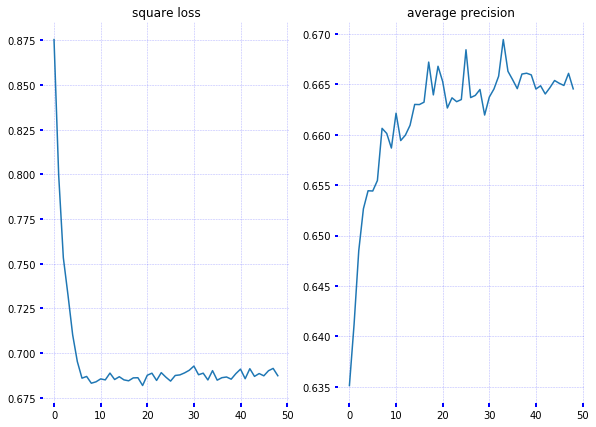

In [11]:
burnin = 1

fig = plt.figure(figsize=(15, 7))
fig.add_axes()

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)

for ax in [ax1, ax2]:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.grid(color='b', linestyle='--', linewidth=0.5, alpha=0.3)
    ax.tick_params(direction='out', color='b', width='2')
    
ax1.set_title('square loss')
ax1.plot(np.arange(len(loss_history[burnin:])), loss_history[burnin:])
ax2.set_title('average precision')
ax2.plot(np.arange(len(avgp_history[burnin:])), avgp_history[burnin:])